## Setup

In [1]:
%matplotlib inline

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo
from aif360.metrics import BinaryLabelDatasetMetric
from oversample import label_bias, selection_bias 
from sklearn import preprocessing
from privacy_meter.dataset import Dataset
from aif360.datasets import BinaryLabelDataset
import os
import shutil
import glob
from datetime import datetime

## Arguments & Initializations

In [3]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex', 'law_race', 'law_aif_gender', 'law_aif_race'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [4]:
sys.argv = ['']
args = vars(ap.parse_args())

In [5]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [6]:
DATASET = "law_gender_aif"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])
ATTACK = "mia1"

In [7]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# cpp_metrics = defaultdict(list) 
# cpp_mia_metrics = defaultdict(list)

# pr_orig_metrics = defaultdict(list) 
# ro_metrics = defaultdict(list) 

In [8]:
# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [9]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [10]:
df, _ = dataset_orig.convert_to_dataframe()

In [11]:
df[['gender', 'gpa_class']].value_counts()

gender  gpa_class
1.0     0.0          8704
0.0     0.0          6920
1.0     1.0          3920
0.0     1.0          2798
Name: count, dtype: int64

In [12]:
dataset_orig.features.shape

(22342, 4)

In [13]:
privileged_groups

[{'gender': 1}]

In [14]:
sens_attr

'gender'

In [15]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [16]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

[[1.         1.         0.89189189 0.925     ]
 [1.         1.         0.91891892 0.825     ]
 [1.         1.         0.7972973  0.85      ]
 ...
 [1.         0.         0.91891892 0.9       ]
 [0.         0.         0.35135135 0.725     ]
 [1.         1.         0.51351351 0.95      ]]
no bias type specified


## Run Mitigating Algorithms

### Setup for MIA2

In [17]:
seed = 1234
np.random.seed(seed)

In [18]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [19]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)
    
    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [20]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [21]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [22]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [23]:
# target_dataset = None
# reference_dataset = None

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
def prepare_datasets():
    target_dataset = None
    reference_dataset = None
    
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()

        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)

        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
#         dataset_orig_val = create_binary_label_dataset(
#             dataset_orig=dataset_orig,
#             X=X[valid_index],
#             y=y_true[valid_index],
#             sensitive_features=sensitive_features[valid_index],
#             sens_attr_name=sens_attr,
#             privileged_value=privileged_value,
#             unprivileged_value=unprivileged_value
#         )

        # Convert test dataset
        dataset_orig_test = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        dataset_orig_val = dataset_orig_test
        
    return dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset

In [26]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

try:
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()
except ValueError as e:
    print("Error detected: No samples generated. Adjusting datasets...")
    delete_logs()
    # percentage of favor and unfavor
    priv_metric_orig = defaultdict(float)
    favor_metric_orig = defaultdict(float)
    favor_metric_transf = defaultdict(float)

    # for each pre-processing approach, we create a mia_metric_results
    orig_metrics = defaultdict(list)
    orig_mia_metrics = defaultdict(list)

    transf_metrics = defaultdict(list) 
    transf_mia_metrics = defaultdict(list) 

    reweigh_metrics = defaultdict(list) 
    reweigh_mia_metrics = defaultdict(list) 

    dir_metrics = defaultdict(list) 
    dir_mia_metrics = defaultdict(list) 

    eg_metrics = defaultdict(list) 
    eg_mia_metrics = defaultdict(list) 
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        while(base_rate_privileged >= base_rate_unprivileged and (base_rate_privileged - base_rate_unprivileged) <= 0.05):
            print("DIFFERENCE IS TOO LOW, GETTING DATASETS AGAIN")
            dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
             # check fairness on the original data
            metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                         unprivileged_groups=unprivileged_groups,
                                                         privileged_groups=privileged_groups)
            print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
            base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
            base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
        print("ORIG MIA METRICS ", orig_mia_metrics)
        
        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()

ITERATION  0
privileged vs. unprivileged:  6309.0 4862.0
base_pos unpriv:  0.2914438502673797
base_pos priv:  0.3067047075606277
DIFFERENCE IS GOOD
base_pos unpriv:  0.2914438502673797
base_pos priv:  0.3067047075606277
no bias type specified
#### Training Dataset shape
(11171, 4)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['gender']
#### Privileged and unprivileged protected groups
[{'gender': 1}] [{'gender': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'gender', 'lsat', 'ugpa']
number of favorable labels:  3352
Difference in mean outcomes between unprivileged and privileged groups = -0.015261
#### Train shape, validation shape, test shape
(11171, 4) (11171, 4) (11171, 4)
#######################################################################
                    dt
#######################################################################

------------------------------

[

Best thresh:  0.26
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.54
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.07
  Positive predictive value: 0.53
  Optimal thershold: -0.41897882727488733
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7819, Test = 7805
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.09
  Positive predictive value: 0.53
  Optimal thershold: -0.41897882727488733
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3352, Test = 3366
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.08
  Positive predictive value: 0.63
  Optimal thershold: -1.3993664426872434
)
MIA_Result(
  Name: subpopulation_0.0_label_0.

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3386
Number of test samples (ntest): 3534
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1361
Number of test samples (ntest): 1437
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4428
Number of test samples (ntest): 4276
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1996
Number of test samples (ntest): 1924
TEST
Best thresh:  0.3
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.54
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -0.4274440148269396
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7814, Test = 7810
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.

Number of training samples (ntrain): 3386
Number of test samples (ntest): 3534
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1361
Number of test samples (ntest): 1437
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4428
Number of test samples (ntest): 4276
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1996
Number of test samples (ntest): 1924
TEST
Best thresh:  0.31
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.47
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: -0.37690768342688274
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7814, Test = 7810
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.05
 

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3459
Number of test samples (ntest): 3461
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1427
Number of test samples (ntest): 1371
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4334
Number of test samples (ntest): 4370
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1951
Number of test samples (ntest): 1969
TEST
Best thresh:  0.34
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.30
  Test Accuracy (TNR): 0.73
  Attacker advantage: 0.02
  Positive predictive value: 0.55
  Optimal thershold: -0.3313571359544425
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7793, Test = 7831
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR):

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3459
Number of test samples (ntest): 3461
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1427
Number of test samples (ntest): 1371
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4334
Number of test samples (ntest): 4370
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1951
Number of test samples (ntest): 1969
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.02
  Positive predictive value: 0.54
  Optimal thershold: -0.04900966839495688
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7793, Test = 7831
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.41
  Att

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3571
Number of test samples (ntest): 3349
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1390
Number of test samples (ntest): 1408
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4269
Number of test samples (ntest): 4435
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1941
Number of test samples (ntest): 1979
TEST
Best thresh:  0.3
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.06
  Positive predictive value: 0.53
  Optimal thershold: -1.041453874828161
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7840, Test = 7784
  AUC: 0.52
  Privacy Risk: 0.53
  Accurac

#### Train shape, validation shape, test shape
(11171, 4) (11171, 4) (11171, 4)
#######################################################################
                    dt
#######################################################################

------------------------------

[INFO] Original Results......

------------------------------

[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3520
Number of test samples (ntest): 3400
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1385
Number of test samples (ntest): 1413
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4318
Number of test samples (ntest): 4386
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1948
Number of test samples (ntest): 1972
TEST
Best thresh:  0.3
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privac

Number of training samples (ntrain): 3520
Number of test samples (ntest): 3400
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1385
Number of test samples (ntest): 1413
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4318
Number of test samples (ntest): 4386
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1948
Number of test samples (ntest): 1972
TEST
Best thresh:  0.28
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -0.8054583067388658
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7838, Test = 7786
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.04
  

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3423
Number of test samples (ntest): 3497
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1397
Number of test samples (ntest): 1401
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4404
Number of test samples (ntest): 4300
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1947
Number of test samples (ntest): 1973
TEST
Best thresh:  0.27
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.04
  Positive predictive value: 0.55
  Optimal thershold: -0.43286408229627876
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7827, Test = 7797
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR)

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3423
Number of test samples (ntest): 3497
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1397
Number of test samples (ntest): 1401
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4404
Number of test samples (ntest): 4300
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1947
Number of test samples (ntest): 1973
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -0.030336076013716493
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7827, Test = 7797
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.32
  At

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3462
Number of test samples (ntest): 3458
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1385
Number of test samples (ntest): 1413
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4338
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1986
Number of test samples (ntest): 1934
TEST
Best thresh:  0.3
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.06
  Positive predictive value: 0.53
  Optimal thershold: -0.455103089199936
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7800, Test = 7824
  AUC: 0.54
  Privacy Risk: 0.55
  Accurac

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3468
Number of test samples (ntest): 3452
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1416
Number of test samples (ntest): 1382
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4339
Number of test samples (ntest): 4365
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1948
Number of test samples (ntest): 1972
TEST
Best thresh:  0.28
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.50
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -0.39204208777602373
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7807, Test = 7817
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.69
  Test A

Number of training samples (ntrain): 3468
Number of test samples (ntest): 3452
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1416
Number of test samples (ntest): 1382
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4339
Number of test samples (ntest): 4365
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1948
Number of test samples (ntest): 1972
TEST
Best thresh:  0.27
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -0.4576973690861886
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7807, Test = 7817
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.24
  Attacker advantage: 0.04
  

Number of training samples (ntrain): 3466
Number of test samples (ntest): 3454
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1415
Number of test samples (ntest): 1383
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4340
Number of test samples (ntest): 4364
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1950
Number of test samples (ntest): 1970
TEST
Best thresh:  0.28
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -0.6286086594223742
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7806, Test = 7818
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.03
  

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3466
Number of test samples (ntest): 3454
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1415
Number of test samples (ntest): 1383
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4340
Number of test samples (ntest): 4364
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1950
Number of test samples (ntest): 1970
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -0.061530762961538706
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7806, Test = 7818
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.47
  At

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3459
Number of test samples (ntest): 3461
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1391
Number of test samples (ntest): 1407
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4378
Number of test samples (ntest): 4326
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1943
Number of test samples (ntest): 1977
TEST
Best thresh:  0.29000000000000004
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.06
  Positive predictive value: 0.53
  Optimal thershold: -0.5108256237659907
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7837, Test = 7787
  AUC: 0.53
  Privacy Ris

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3439
Number of test samples (ntest): 3481
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1446
Number of test samples (ntest): 1352
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4336
Number of test samples (ntest): 4368
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1950
Number of test samples (ntest): 1970
TEST
Best thresh:  0.32
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -0.6539264674066639
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7775, Test = 7849
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0

Number of training samples (ntrain): 3439
Number of test samples (ntest): 3481
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1446
Number of test samples (ntest): 1352
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4336
Number of test samples (ntest): 4368
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1950
Number of test samples (ntest): 1970
TEST
Best thresh:  0.31
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -0.65211506233791
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7775, Test = 7849
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.03
  Po

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3402
Number of test samples (ntest): 3518
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1444
Number of test samples (ntest): 1354
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4315
Number of test samples (ntest): 4389
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 2010
Number of test samples (ntest): 1910
TEST
Best thresh:  0.26
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.02
  Positive predictive value: 0.54
  Optimal thershold: -1.0680511873474268
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7717, Test = 7907
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.48
  Test Accuracy (TNR):

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3402
Number of test samples (ntest): 3518
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1444
Number of test samples (ntest): 1354
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4315
Number of test samples (ntest): 4389
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 2010
Number of test samples (ntest): 1910
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: -0.3705329395143148
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7717, Test = 7907
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.51
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.35
  Atta

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3445
Number of test samples (ntest): 3475
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1372
Number of test samples (ntest): 1426
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4356
Number of test samples (ntest): 4348
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1998
Number of test samples (ntest): 1922
TEST
Best thresh:  0.31
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: -0.6190392084062235
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7801, Test = 7823
  AUC: 0.54
  Privacy Risk: 0.53
  Accur

ITERATION  13
privileged vs. unprivileged:  6320.0 4851.0
base_pos unpriv:  0.2945784374355803
base_pos priv:  0.30838607594936707
DIFFERENCE IS GOOD
base_pos unpriv:  0.2945784374355803
base_pos priv:  0.30838607594936707
no bias type specified
#### Training Dataset shape
(11171, 4)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['gender']
#### Privileged and unprivileged protected groups
[{'gender': 1}] [{'gender': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'gender', 'lsat', 'ugpa']
number of favorable labels:  3378
Difference in mean outcomes between unprivileged and privileged groups = -0.013808
#### Train shape, validation shape, test shape
(11171, 4) (11171, 4) (11171, 4)
#######################################################################
                    dt
#######################################################################

------------------------------

Best thresh:  0.32
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.06
  Positive predictive value: 0.53
  Optimal thershold: -0.6286086594223742
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7793, Test = 7831
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.08
  Positive predictive value: 0.52
  Optimal thershold: -0.6286086594223742
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3378, Test = 3340
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.10
  Positive predictive value: 0.59
  Optimal thershold: -1.2093636529608123
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3415
Number of test samples (ntest): 3505
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1364
Number of test samples (ntest): 1434
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4376
Number of test samples (ntest): 4328
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 2016
Number of test samples (ntest): 1904
TEST
Best thresh:  0.25
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -0.6312717768418579
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7791, Test = 7833
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.53
  Test Accuracy (TNR): 0

Number of training samples (ntrain): 3415
Number of test samples (ntest): 3505
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1364
Number of test samples (ntest): 1434
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4376
Number of test samples (ntest): 4328
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 2016
Number of test samples (ntest): 1904
TEST
Best thresh:  0.3
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -0.47683864293676326
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7791, Test = 7833
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.46
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.04
  

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3434
Number of test samples (ntest): 3486
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1417
Number of test samples (ntest): 1381
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4382
Number of test samples (ntest): 4322
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1938
Number of test samples (ntest): 1982
TEST
Best thresh:  0.34
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.03
  Positive predictive value: 0.55
  Optimal thershold: -0.3746934494414107
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7816, Test = 7808
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR):

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3434
Number of test samples (ntest): 3486
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1417
Number of test samples (ntest): 1381
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4382
Number of test samples (ntest): 4322
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1938
Number of test samples (ntest): 1982
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.41
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.03
  Positive predictive value: 0.55
  Optimal thershold: -0.02265712050420227
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7816, Test = 7808
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.47
  Att

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3453
Number of test samples (ntest): 3467
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1397
Number of test samples (ntest): 1401
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4347
Number of test samples (ntest): 4357
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1974
Number of test samples (ntest): 1946
TEST
Best thresh:  0.33
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.50
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -1.262241712449912
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7800, Test = 7824
  AUC: 0.49
  Privacy Risk: 0.52
  Accura

privileged vs. unprivileged:  6260.0 4911.0
base_pos unpriv:  0.2858888210140501
base_pos priv:  0.31182108626198085
DIFFERENCE IS GOOD
base_pos unpriv:  0.2858888210140501
base_pos priv:  0.31182108626198085
no bias type specified
#### Training Dataset shape
(11171, 4)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['gender']
#### Privileged and unprivileged protected groups
[{'gender': 1}] [{'gender': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'gender', 'lsat', 'ugpa']
number of favorable labels:  3356
Difference in mean outcomes between unprivileged and privileged groups = -0.025932
#### Train shape, validation shape, test shape
(11171, 4) (11171, 4) (11171, 4)
#######################################################################
                    dt
#######################################################################

------------------------------

[INFO] Origi

Best thresh:  0.26
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: -0.6325225587435105
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7815, Test = 7809
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.587786664902119
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3356, Test = 3362
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.10
  Positive predictive value: 0.62
  Optimal thershold: -1.1676051601550612
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
 

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3448
Number of test samples (ntest): 3472
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1391
Number of test samples (ntest): 1407
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4348
Number of test samples (ntest): 4356
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1984
Number of test samples (ntest): 1936
TEST
Best thresh:  0.28
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: -1.1856236656577395
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7796, Test = 7828
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3448
Number of test samples (ntest): 3472
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1391
Number of test samples (ntest): 1407
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4348
Number of test samples (ntest): 4356
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1984
Number of test samples (ntest): 1936
TEST
Best thresh:  0.25
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: -1.1452775967387883
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7796, Test = 7828
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR):

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3449
Number of test samples (ntest): 3471
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1420
Number of test samples (ntest): 1378
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4302
Number of test samples (ntest): 4402
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 2000
Number of test samples (ntest): 1920
TEST
Best thresh:  0.27
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.03
  Positive predictive value: 0.55
  Optimal thershold: -0.6007738604289302
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7751, Test = 7873
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR):

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3449
Number of test samples (ntest): 3471
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1420
Number of test samples (ntest): 1378
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4302
Number of test samples (ntest): 4402
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 2000
Number of test samples (ntest): 1920
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: -0.08643472592239289
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7751, Test = 7873
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.36
  Att

## Display Output

In [27]:
priv_metric_orig_copy = priv_metric_orig

In [28]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 126279.0, 'total_unpriv': 97141.0})

In [29]:
priv_metric_orig

defaultdict(float, {'total_priv': 126279.0, 'total_unpriv': 97141.0})

In [30]:
priv_metric_orig.items()

dict_items([('total_priv', 126279.0), ('total_unpriv', 97141.0)])

In [31]:
priv_metric_orig = priv_metric_orig_copy

In [32]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

law_gender_aif
11171
2)

              total_priv  total_unpriv
num_instance                          
orig             6313.95       4857.05
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.301602       0.698398    0.311341      0.688659      0.288945   
transf      0.311314       0.688686    0.311341      0.688659      0.311280   

         unpriv_unfavor  
dataset                  
orig           0.711055  
transf         0.688720  


# Train/Test Accuracies

In [33]:
def separate_metrics(metrics):
    accuracy_metrics = defaultdict(list)

    # List of accuracy-related keys
    accuracy_keys = [
        'accuracy_train_0_-', 'accuracy_train_0_+',
        'accuracy_train_1_-', 'accuracy_train_1_+',
        'accuracy_test_0_-', 'accuracy_test_0_+',
        'accuracy_test_1_-', 'accuracy_test_1_+',
        'accuracy_train', 'accuracy_test'
    ]

    # Separate accuracy metrics into a new dictionary
    for key in accuracy_keys:
        if key in metrics:
            accuracy_metrics[key] = metrics.pop(key)

    return metrics, accuracy_metrics

In [34]:
orig_metrics, orig_acc = separate_metrics(orig_metrics)
transf_metrics, transf_acc = separate_metrics(transf_metrics)
reweigh_metrics, reweigh_acc = separate_metrics(reweigh_metrics)
dir_metrics, dir_acc = separate_metrics(dir_metrics)
eg_metrics, eg_acc = separate_metrics(eg_metrics)

In [35]:
def calculate_mean_accuracy(acc_metrics):
    mean_accuracies = {key: sum(values) / len(values) for key, values in acc_metrics.items()}
    return mean_accuracies

In [36]:
orig_acc_mean = calculate_mean_accuracy(orig_acc)
transf_acc_mean = calculate_mean_accuracy(transf_acc)
reweigh_acc_mean = calculate_mean_accuracy(reweigh_acc)
dir_acc_mean = calculate_mean_accuracy(dir_acc)
eg_acc_mean = calculate_mean_accuracy(eg_acc)

# Display the results
train_test_data = {
    "orig_acc_mean": orig_acc_mean,
    "transf_acc_mean": transf_acc_mean,
    "reweigh_acc_mean": reweigh_acc_mean,
    "dir_acc_mean": dir_acc_mean,
    "eg_acc_mean": eg_acc_mean
}

## Save Data

In [37]:
# Convert dictionary to DataFrame
train_test_df = pd.DataFrame(train_test_data)

# File path
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_train_test_accuracies_{today}.csv"

# Save to CSV
train_test_df.to_csv(file_path, index=True)

file_path

'./mia1_results/mia1_law_gender_aif_train_test_accuracies_2024-12-31.csv'

In [38]:
train_test_df

,orig_acc_mean,transf_acc_mean,reweigh_acc_mean,dir_acc_mean,eg_acc_mean
accuracy_train_0_-,0.968654,0.961941,0.952199,0.966689,0.954416
accuracy_train_0_+,0.141307,0.184005,0.185220,0.150101,0.154019
accuracy_train_1_-,0.962604,0.966774,0.965922,0.963884,0.953253
accuracy_train_1_+,0.142091,0.127316,0.134085,0.136987,0.152198
accuracy_test_0_-,0.948738,0.941482,0.926047,0.938475,0.939544
accuracy_test_0_+,0.099281,0.110151,0.132784,0.111123,0.120421
accuracy_test_1_-,0.939663,0.947083,0.943061,0.917094,0.934210
accuracy_test_1_+,0.100110,0.088730,0.091287,0.126528,0.114678
accuracy_train,0.716941,0.711773,0.717210,0.717013,0.711874
accuracy_test,0.690663,0.690690,0.687611,0.684782,0.690534


In [39]:
train_test_df.head()

,orig_acc_mean,transf_acc_mean,reweigh_acc_mean,dir_acc_mean,eg_acc_mean
accuracy_train_0_-,0.968654,0.961941,0.952199,0.966689,0.954416
accuracy_train_0_+,0.141307,0.184005,0.185220,0.150101,0.154019
accuracy_train_1_-,0.962604,0.966774,0.965922,0.963884,0.953253
accuracy_train_1_+,0.142091,0.127316,0.134085,0.136987,0.152198
accuracy_test_0_-,0.948738,0.941482,0.926047,0.938475,0.939544


In [40]:
%matplotlib inline
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
# from scipy.stats import ttest_rel
# def paired_t (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
#     return p

# def acc_diff (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     delta = np_a - np_b
#     m = statistics.mean(delta)
#     s = statistics.stdev(delta)
#     return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

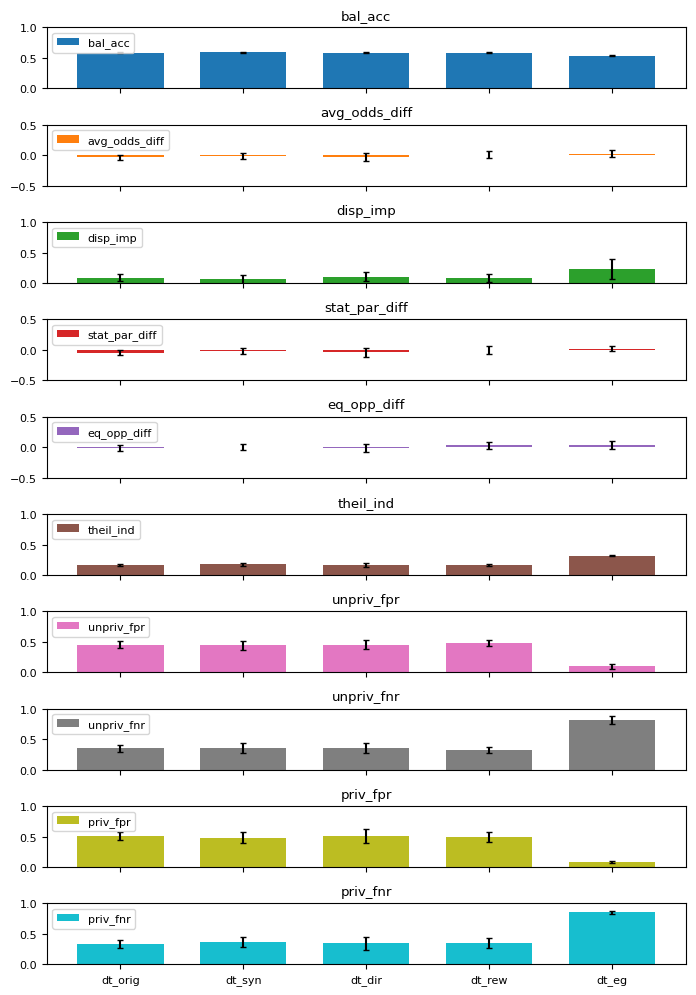

In [41]:
model_type=BASELINE
# Set up plotting options
plt.rcParams.update({'font.size': 8})  # Set global font size
pd.set_option('display.multi_sparse', False)

# Metrics and errors as lists of dictionaries
results = [orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean]
errors = [orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics]

# Classifier bias mitigators (for labels)
index = pd.Series(
    [model_type+'_orig', model_type+'_syn', model_type+'_dir', model_type+'_rew', model_type+'_eg'])

# Create DataFrame for metrics and error bars
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)

# Dynamically generate titles for all metrics in df
titles = list(df.columns)

# Plot fairness metrics with error bars
ax = df.plot.bar(
    yerr=df_error, 
    capsize=2, 
    rot=0, 
    subplots=True, 
    title=titles, 
    fontsize=8, 
    figsize=(7, 10),  # Reduced overall figure size
    legend=True,
    width=0.7  # Adjusted bar width to make bars closer
)

# Adjust Y-axis limits dynamically based on metric names
for i, subplot in enumerate(ax):
    metric = titles[i]
    if "fpr" in metric or "fnr" in metric:  # Subgroup-specific metrics
        subplot.set_ylim([0, 1])  # False positive/negative rates range from 0 to 1
    elif metric in ["bal_acc", "disp_imp", "theil_ind"]:  # General metrics
        subplot.set_ylim([0, 1])
    elif metric in ["avg_odds_diff", "stat_par_diff", "eq_opp_diff"]:  # Difference metrics
        subplot.set_ylim([-0.5, 0.5])  # Allow for negative values

    # Move legend inside the plot
    subplot.legend(loc='upper left', fontsize=8, frameon=True)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

## Save Results

In [42]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
fairness_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        fairness_data.append({
            "Method": method,
            "Metric": key,
            "Mean": metric[key][0],  # Assuming the metric values are single-item lists
            "Error": error[key][0]   # Assuming the error values are single-item lists
        })

# Create DataFrame from the data list
fairness_df = pd.DataFrame(fairness_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_fairness_metrics_{today}.csv"

# Save the DataFrame to CSV
fairness_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./mia1_results/mia1_law_gender_aif_fairness_metrics_2024-12-31.csv


## Visualization of MIA results


### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [43]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [44]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.517469,0.519547,0.539393,0.520992,0.543899,0.520947,0.539612
syn,0.515941,0.517147,0.533050,0.518251,0.536821,0.518997,0.534190
dir,0.527265,0.531569,0.551724,0.529611,0.555084,0.538865,0.556288
rew,0.518080,0.519975,0.539798,0.521702,0.544668,0.520734,0.540122
eg,0.514253,0.518037,0.536935,0.518965,0.542258,0.520357,0.539343


In [45]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [46]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
                       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [47]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.520992,0.520947,0.543899,0.539612
syn,0.518251,0.518997,0.536821,0.534190
dir,0.529611,0.538865,0.555084,0.556288
rew,0.521702,0.520734,0.544668,0.540122
eg,0.518965,0.520357,0.542258,0.539343


<Axes: xlabel='Classifier MIA Attacks'>

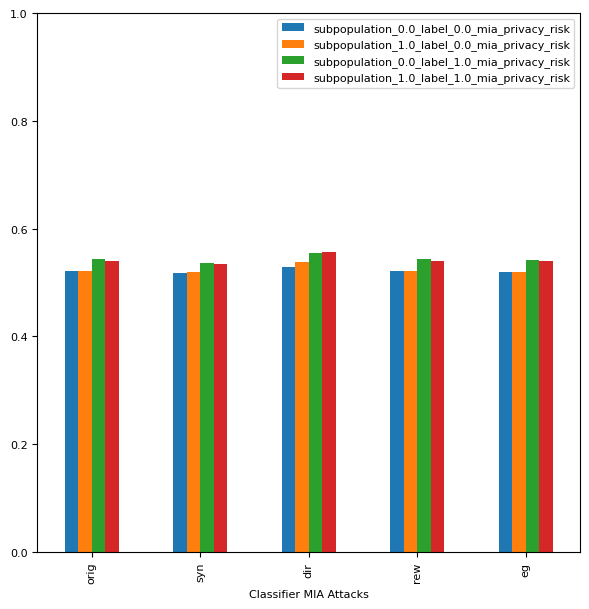

In [48]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [49]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.520992  0.518251  0.529611  0.521702  0.518965
subpopulation_1.0_label_0.0_mia_privacy_risk  0.520947  0.518997  0.538865  0.520734  0.520357
subpopulation_0.0_label_1.0_mia_privacy_risk  0.543899  0.536821  0.555084  0.544668  0.542258
subpopulation_1.0_label_1.0_mia_privacy_risk  0.539612  0.53419   0.556288  0.540122  0.539343


## Save Results

In [50]:
errors

[{'entire_dataset_mia_privacy_risk': 0.002386597854807511,
  'entire_dataset_label_0.0_mia_privacy_risk': 0.0027789452296167784,
  'entire_dataset_label_1.0_mia_privacy_risk': 0.005464263875682534,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.0053538768683540315,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.00772999131528671,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.0037610461012469684,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.007386928050160634},
 {'entire_dataset_mia_privacy_risk': 0.0027918719592858947,
  'entire_dataset_label_0.0_mia_privacy_risk': 0.002908208376993861,
  'entire_dataset_label_1.0_mia_privacy_risk': 0.005004886816291437,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.005594950255143521,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.007856791188412933,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.00310566240557245,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.007491469508791726},
 {'entire_dataset_mia_priv

In [51]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
pr_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        pr_data.append({
            "Method": method,
            "Metric": key,
            "Mean Privacy Risk": metric[key],  # Privacy risk mean
            "Error": error[key]               # Privacy risk error
        })

# Create DataFrame from the data list
pr_df = pd.DataFrame(pr_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_mia_privacy_risks_metrics_{today}.csv"

# Save the DataFrame to CSV
pr_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./mia1_results/mia1_law_gender_aif_mia_privacy_risks_metrics_2024-12-31.csv


# Main Bar Graph Visualization

In [52]:
# Subpopulations and fairness methods
subpopulations = {
    'subpopulation_0.0_label_0.0_mia_privacy_risk': "Unprivileged Unfavorable", 
    'subpopulation_0.0_label_1.0_mia_privacy_risk': "Unprivileged Favorable", 
    'subpopulation_1.0_label_0.0_mia_privacy_risk': "Privileged Unfavorable",
    'subpopulation_1.0_label_1.0_mia_privacy_risk': "Privileged Favorable"
}

fairness_methods = ["syn", "dir", "rew", "eg"]

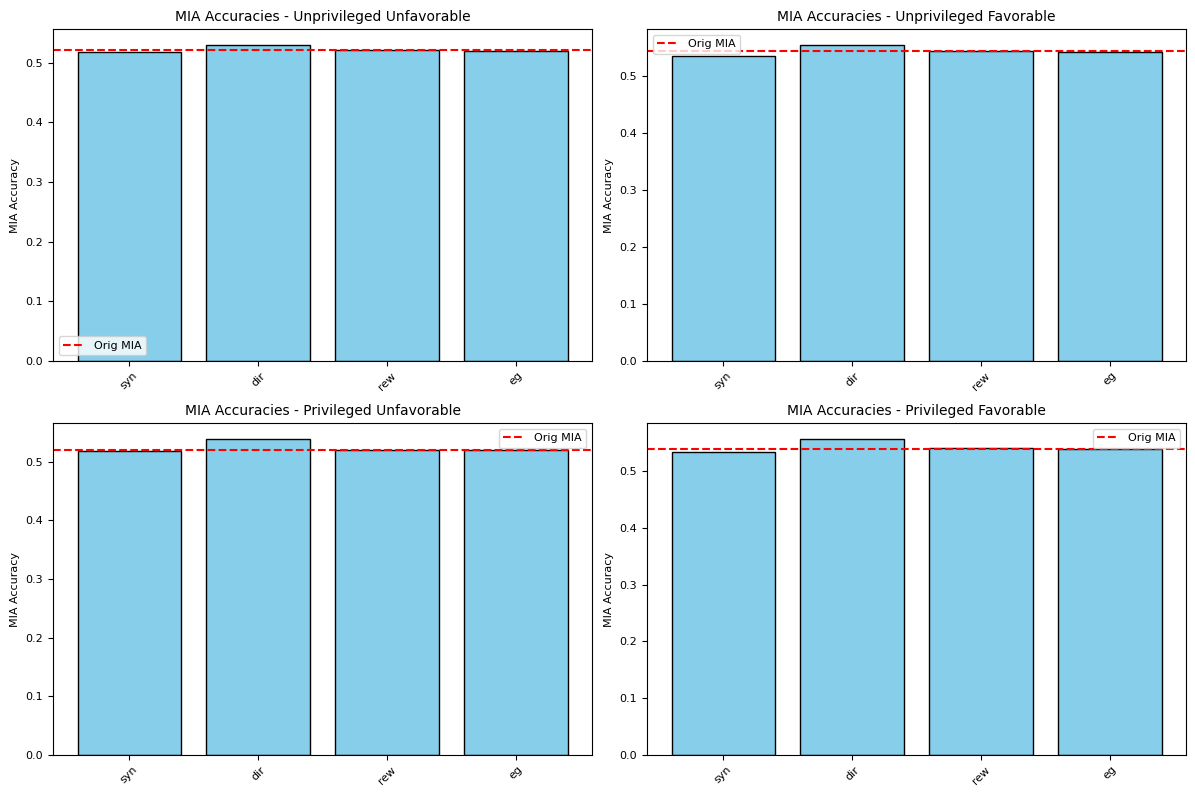

In [53]:
# Combine results into a list
all_results = [
    transf_mia_metrics_mean,
    dir_mia_metrics_mean,
    reweigh_mia_metrics_mean,
    eg_mia_metrics_mean
]

# Organize data for plotting
data = {subpopulations[key]: [results[key] for results in all_results] for key in subpopulations.keys()}
orig_values = orig_mia_metrics_mean

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
idx = 0

for key, value in subpopulations.items():
    accuracies = data[value]
    ax = axes[idx]
    
    # Plot bar chart (excluding 'orig')
    ax.bar(fairness_methods, accuracies, color='skyblue', edgecolor='black')
    
    # Add dashed line for 'orig' MIA accuracy
    ax.axhline(orig_values[key], color='red', linestyle='--', label='Orig MIA')
    
    # Title and labels
    ax.set_title(f"MIA Accuracies - {value}", fontsize=10)
    ax.set_ylabel("MIA Accuracy")
    ax.set_xticks(np.arange(len(fairness_methods)))
    ax.set_xticklabels(fairness_methods, rotation=45)
    ax.legend()
    
    idx = idx + 1

plt.tight_layout()
plt.show()

### Visualizing using novel technique

In [54]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [55]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [56]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.521305
1,orig,entire_dataset_mia_privacy_risk,0.520007
2,orig,entire_dataset_mia_privacy_risk,0.514099
3,orig,entire_dataset_mia_privacy_risk,0.518575
4,orig,entire_dataset_mia_privacy_risk,0.520410
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.531778
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.536740
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.536792
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.546075


In [57]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.521305
1,orig,entire_dataset_mia_privacy_risk,0.520007
2,orig,entire_dataset_mia_privacy_risk,0.514099
3,orig,entire_dataset_mia_privacy_risk,0.518575
4,orig,entire_dataset_mia_privacy_risk,0.520410
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.531778
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.536740
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.536792
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.546075


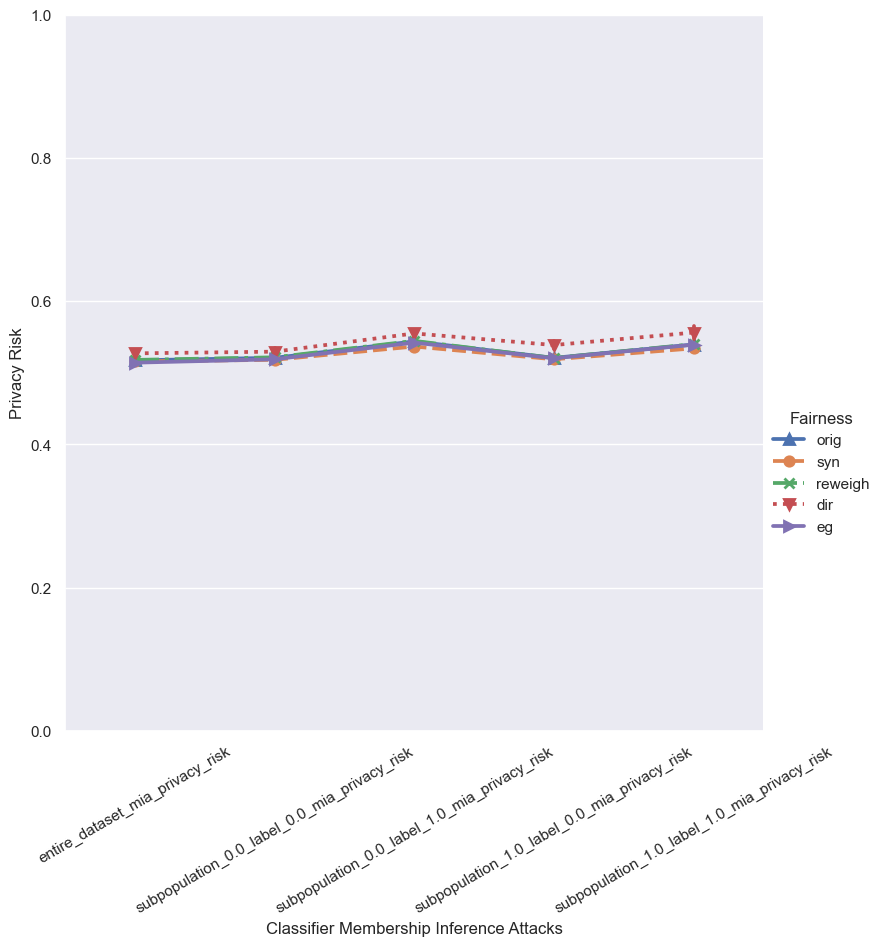

In [58]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [59]:
from sklearn.metrics import RocCurveDisplay, auc

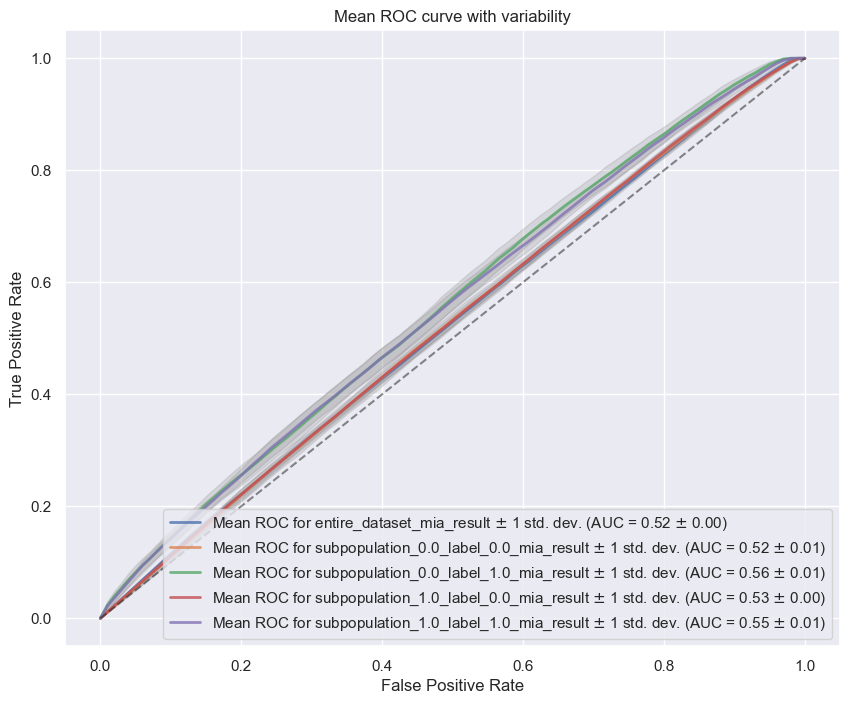

In [60]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.55
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: -0.4274440148269396
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.54
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -0.4274440148269396
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.53
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.03
  Positive predictive value: 0.55
  Optimal thershold: -0.4571371186524852
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy R

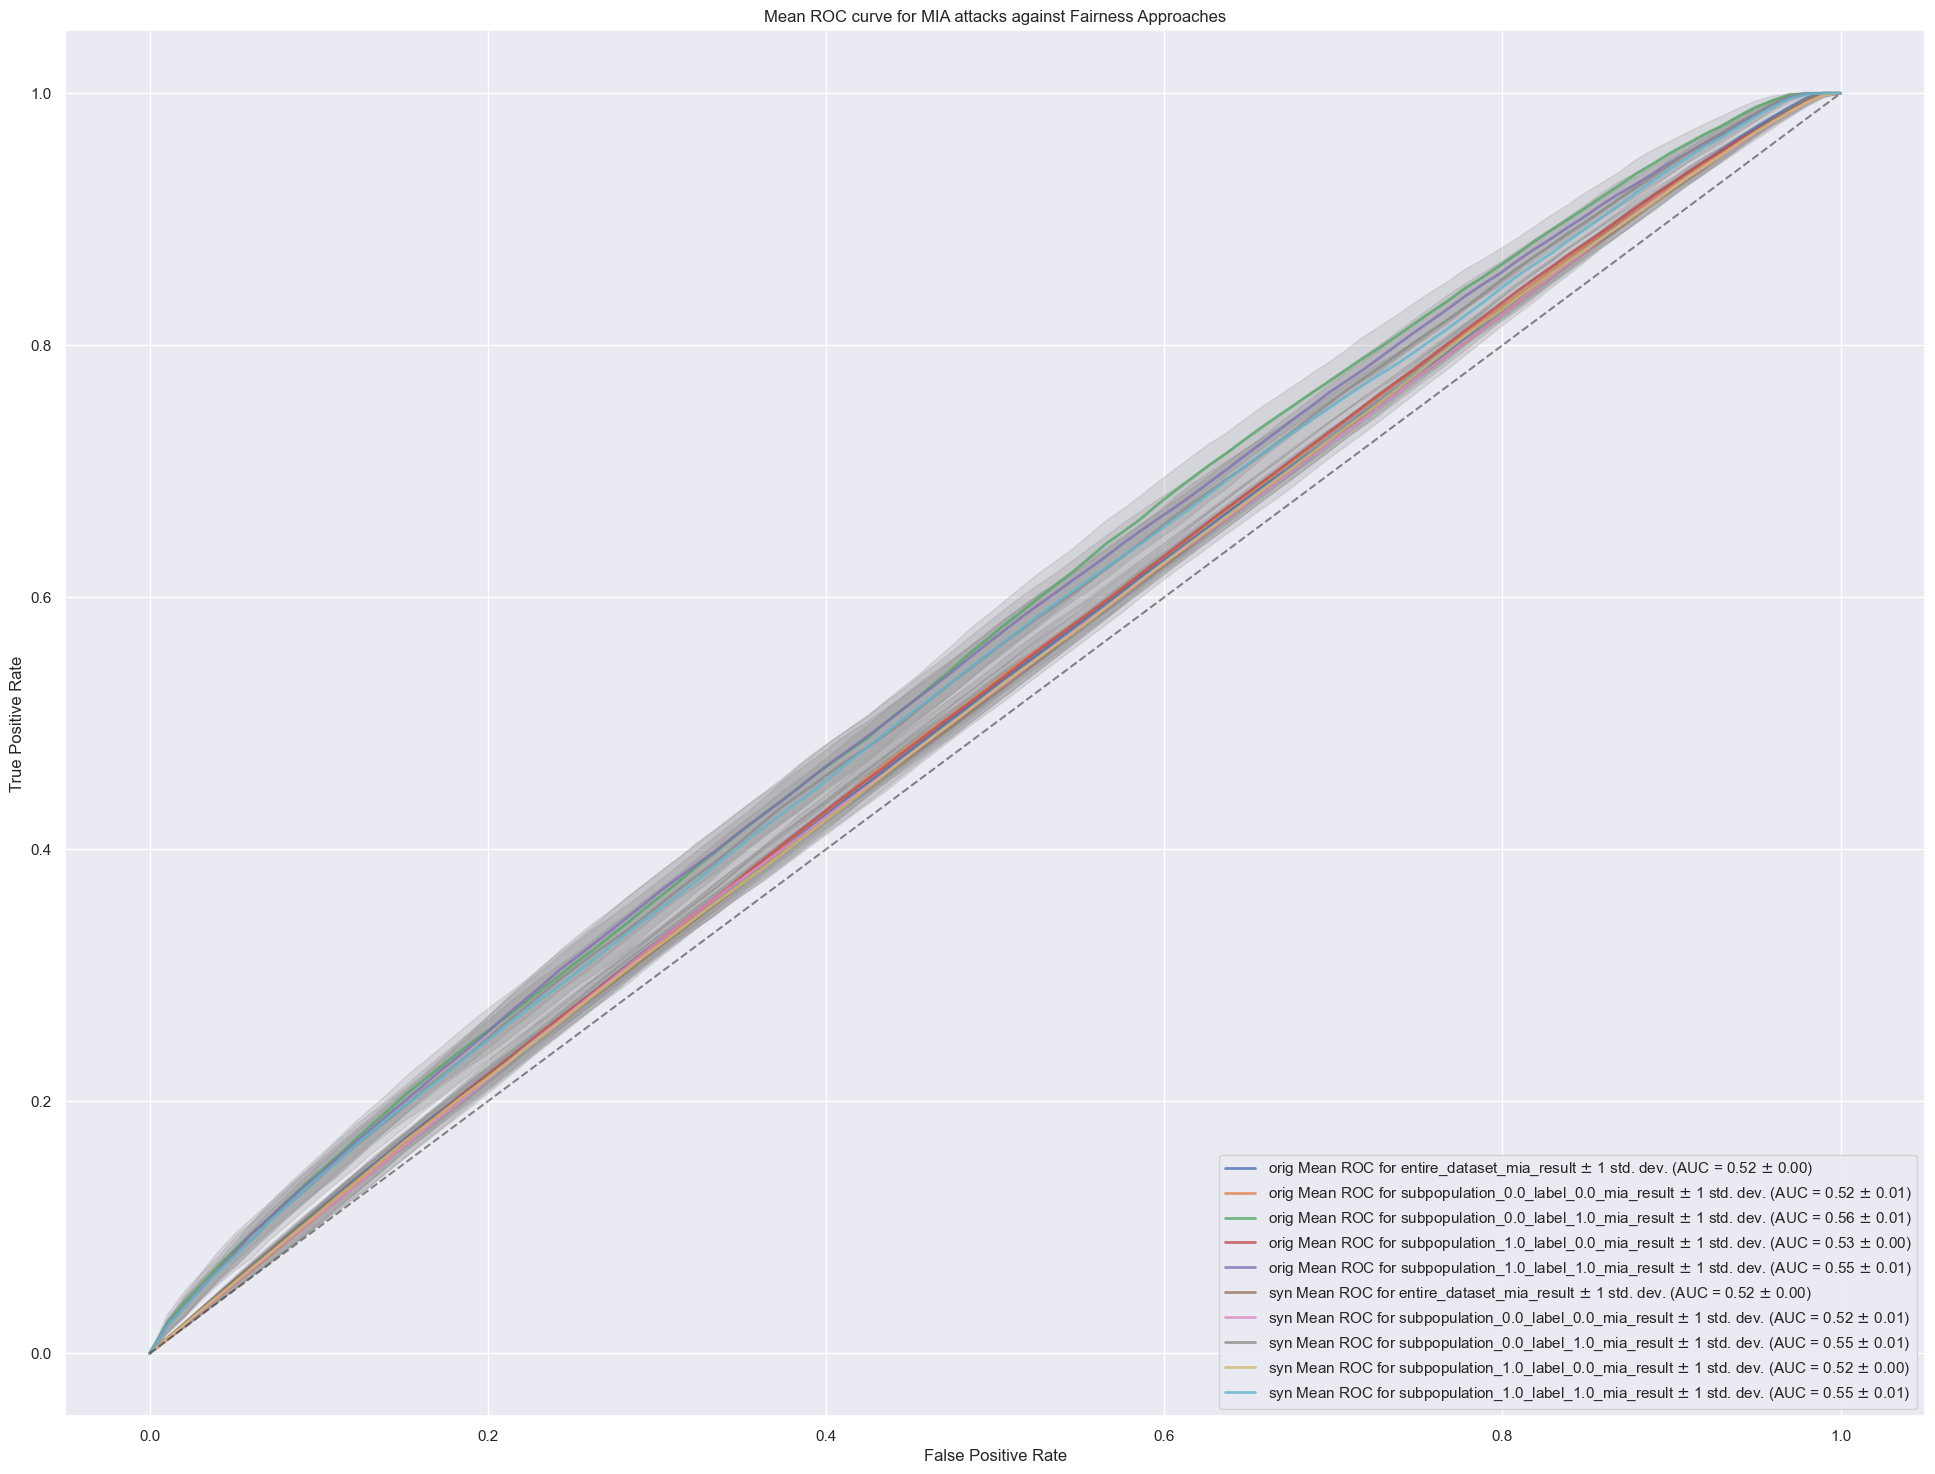

In [61]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

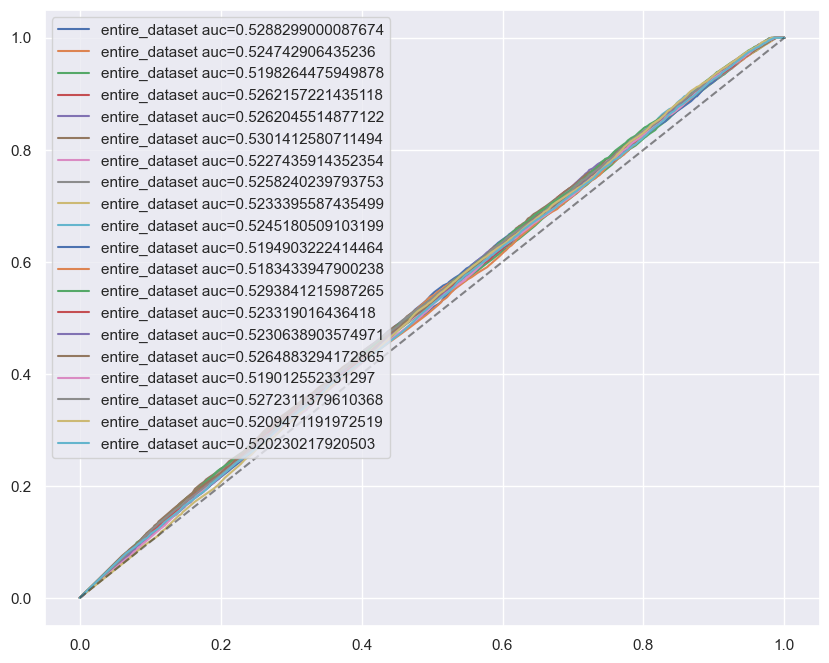

In [62]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [63]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [64]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.523995,0.525216,0.556398,0.524758,0.558448,0.525522,0.554587
syn,0.520875,0.521487,0.547576,0.521155,0.548670,0.521676,0.546427
dir,0.521243,0.519991,0.556170,0.522090,0.564637,0.518712,0.549640
rew,0.524573,0.525370,0.557676,0.525207,0.559899,0.525349,0.555936
egr,0.517845,0.522109,0.549483,0.520557,0.552338,0.523653,0.552150


<Axes: xlabel='Classifier MIA Attacks'>

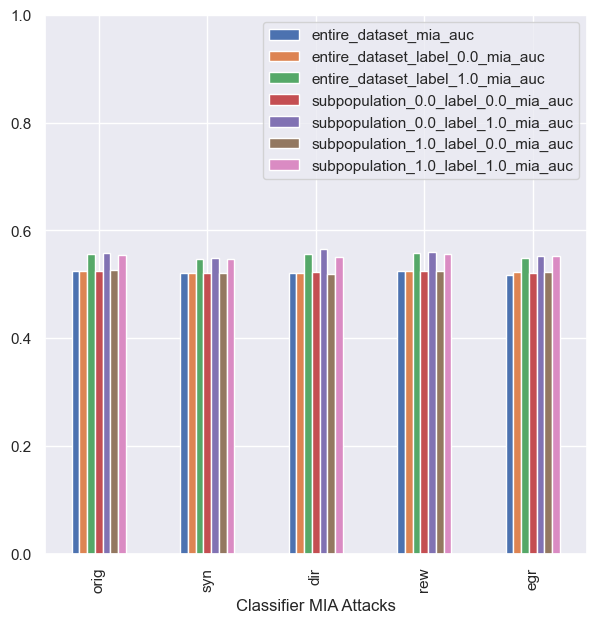

In [65]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [66]:
# Creating data structures to plot point categorical plot from seaborn

In [67]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [68]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.042610330319577505],
 ['orig', 'entire_dataset', 0.040014322800107416],
 ['orig', 'entire_dataset', 0.028198012711485032],
 ['orig', 'entire_dataset', 0.03714976277862325],
 ['orig', 'entire_dataset', 0.04081998030614986],
 ['orig', 'entire_dataset', 0.04108853280816405],
 ['orig', 'entire_dataset', 0.03133112523498349],
 ['orig', 'entire_dataset', 0.03759735028198008],
 ['orig', 'entire_dataset', 0.030614985229612368],
 ['orig', 'entire_dataset', 0.037328797779966005],
 ['orig', 'entire_dataset', 0.03115209023364074],
 ['orig', 'entire_dataset', 0.027660907707456772],
 ['orig', 'entire_dataset', 0.038940112792050896],
 ['orig', 'entire_dataset', 0.03240533524304001],
 ['orig', 'entire_dataset', 0.032494852743711444],
 ['orig', 'entire_dataset', 0.03535941276519561],
 ['orig', 'entire_dataset', 0.02954077522155585],
 ['orig', 'entire_dataset', 0.038313490287351204],
 ['orig', 'entire_dataset', 0.03741831528063744],
 ['orig', 'entire_dataset', 0.02873511771

In [69]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.042610
1,orig,entire_dataset,0.040014
2,orig,entire_dataset,0.028198
3,orig,entire_dataset,0.037150
4,orig,entire_dataset,0.040820
...,...,...,...
695,egr,subpopulation_1.0_label_1.0,0.063555
696,egr,subpopulation_1.0_label_1.0,0.073480
697,egr,subpopulation_1.0_label_1.0,0.073583
698,egr,subpopulation_1.0_label_1.0,0.092150


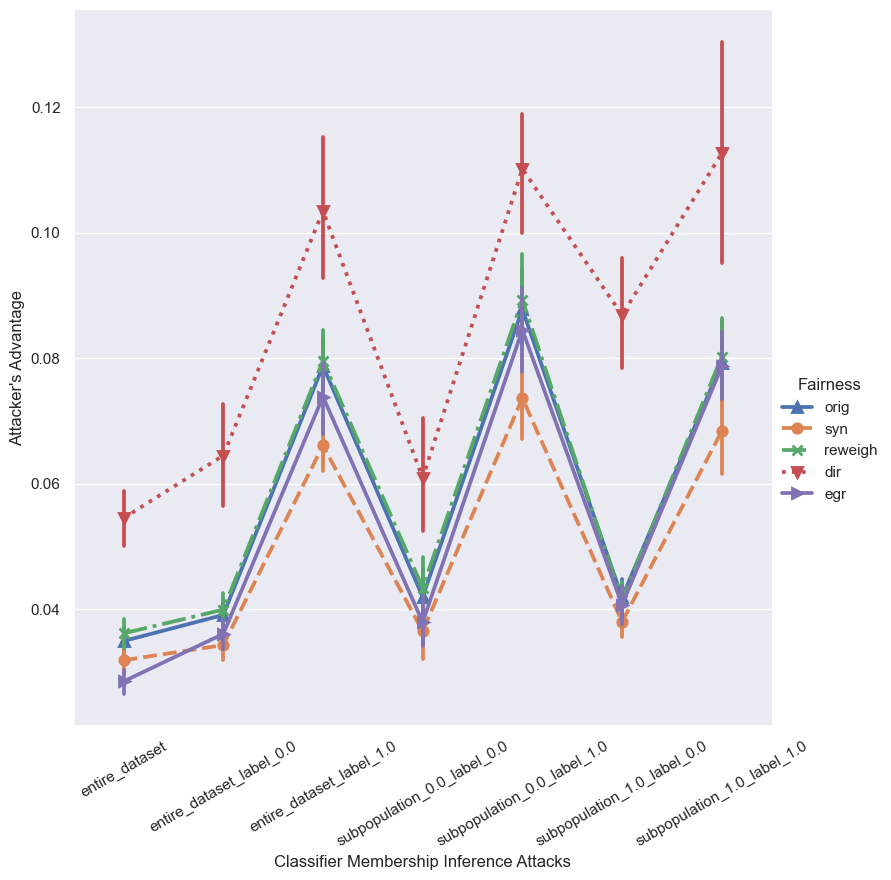

In [70]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


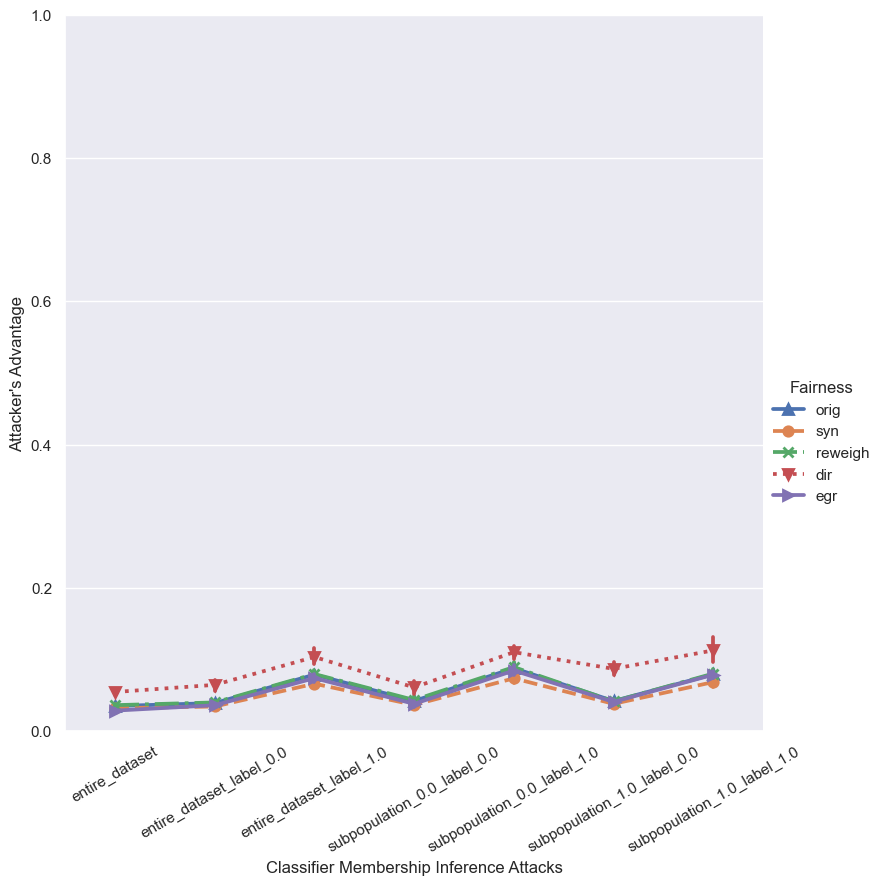

In [71]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [72]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.042610,0.049257,0.080368,0.049694,0.094451,0.050118,0.072768
1,0.040014,0.041621,0.069211,0.043294,0.089087,0.044169,0.059568
2,0.028198,0.035641,0.052857,0.024110,0.063046,0.045434,0.060592
3,0.037150,0.035809,0.079603,0.040006,0.097962,0.034865,0.079064
4,0.040820,0.040185,0.078001,0.040622,0.101935,0.041925,0.073058
5,0.041089,0.045997,0.078609,0.073242,0.083469,0.033628,0.082486
6,0.031331,0.035489,0.074080,0.044696,0.094582,0.033784,0.061177
7,0.037597,0.043734,0.070165,0.045723,0.075364,0.045753,0.072251
8,0.030615,0.032692,0.082981,0.036682,0.114147,0.031055,0.066156
9,0.037329,0.030556,0.096589,0.028803,0.087736,0.036792,0.103174


In [73]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [74]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.034939,0.039094,0.078785,0.041984,0.087799,0.041895,0.079224
syn,0.031882,0.034295,0.066100,0.036503,0.073642,0.037994,0.068380
dir,0.054530,0.064494,0.103448,0.060928,0.110168,0.086872,0.112651
rew,0.036161,0.039951,0.079596,0.043405,0.089336,0.041469,0.080245
egr,0.028507,0.036074,0.073870,0.037930,0.084516,0.040713,0.078686


<Axes: xlabel='Classifier MIA Attacks'>

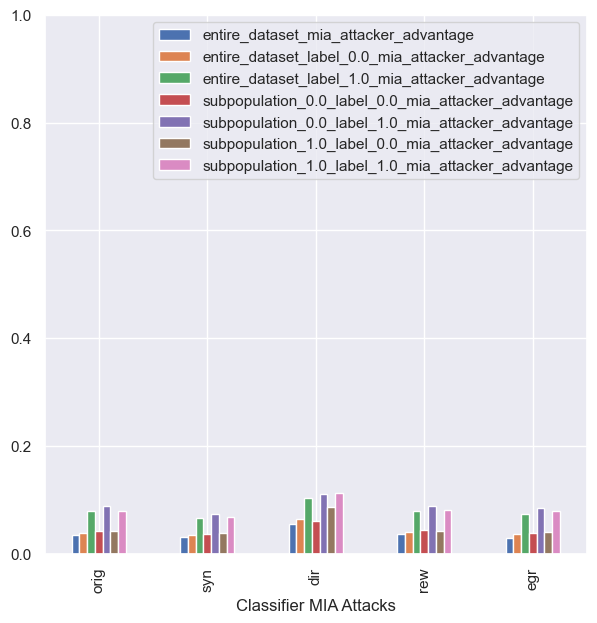

In [75]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [76]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [77]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.542713567839196],
 ['orig', 'entire_dataset', 0.5320715036803365],
 ['orig', 'entire_dataset', 0.5476900149031296],
 ['orig', 'entire_dataset', 0.5339157245632066],
 ['orig', 'entire_dataset', 0.5332581736189402],
 ['orig', 'entire_dataset', 0.543559593800107],
 ['orig', 'entire_dataset', 0.5438418651799289],
 ['orig', 'entire_dataset', 0.532698926908281],
 ['orig', 'entire_dataset', 0.5518749999999999],
 ['orig', 'entire_dataset', 0.5281135049921177],
 ['orig', 'entire_dataset', 0.5395292697646349],
 ['orig', 'entire_dataset', 0.5433266932270916],
 ['orig', 'entire_dataset', 0.549800796812749],
 ['orig', 'entire_dataset', 0.5358925143953934],
 ['orig', 'entire_dataset', 0.5280701754385965],
 ['orig', 'entire_dataset', 0.5563234277816171],
 ['orig', 'entire_dataset', 0.5247664874044722],
 ['orig', 'entire_dataset', 0.5449482895783612],
 ['orig', 'entire_dataset', 0.5162513542795233],
 ['orig', 'entire_dataset', 0.5476190476190477],
 ['orig', 'entire_datase

In [78]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.542714
1,orig,entire_dataset,0.532072
2,orig,entire_dataset,0.547690
3,orig,entire_dataset,0.533916
4,orig,entire_dataset,0.533258
...,...,...,...
695,egr,subpopulation_1.0_label_1.0,0.656716
696,egr,subpopulation_1.0_label_1.0,0.818182
697,egr,subpopulation_1.0_label_1.0,0.621359
698,egr,subpopulation_1.0_label_1.0,0.666667


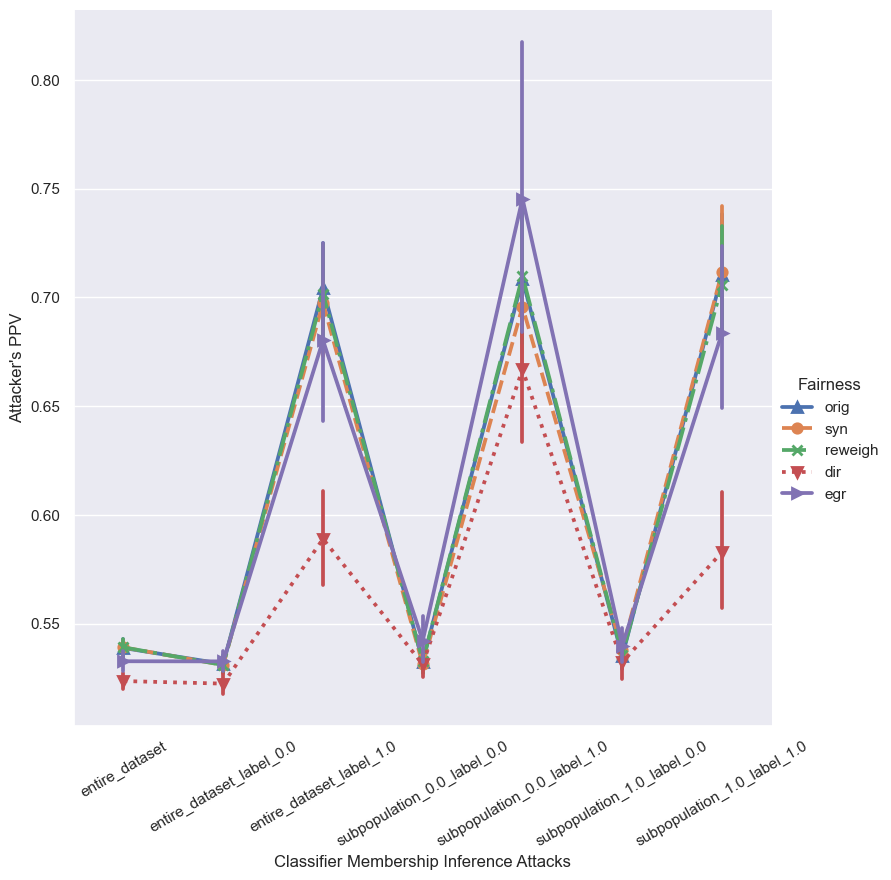

In [79]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )
